# 데이터 로드

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 19.6 MB/s 
     |████████████████████████████████| 448 kB 20.5 MB/s 
     |████████████████████████████████| 86 kB 7.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
# 필요 프레임워크 및 라이브러리 준비
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# 사전에 정제+정규화된 훈련용 통합 데이터 로드
total_data = pd.read_table('clean_naver_shopping_review_total_data.txt')

In [4]:
# 통합 데이터 확인
print(len(total_data))
print(total_data[:3])

199908
   ratings                                           document  label
0        2                              입고다니기 좀그래요 실내에서만 입으세요      0
1        4  포장박스가 살짝오픈되어 있어서 조금 그랬는데 상품은 이상없었고 예상했던맛이며 공복에...      1
2        2         직원분 실수로 잘못 배달되어져서 간장소스거 와버렸죠그래도 와사비는 맛좋으네요      0


# 토큰화

In [5]:
# 불용어 정의 (한국어 조사, 접속사 등) 18
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [6]:
# 훈련데이터에 형태소 분석기를 사용하여 토큰화를 하면서 불용어 제거
okt = Okt()
X_total = []
for sentence in total_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_total.append(temp_X)

In [7]:
print(len(X_total))
print(X_total[:3])

199908
[['입다', '그렇다', '실내', '에서만', '입다'], ['포장', '박스', '살짝', '오픈', '되어다', '있다', '조금', '그랬는데', '상품', '이상', '없다', '예상', '맛', '이며', '공복', '꼭꼭', '씹다', '먹다', '혈당', '빠르다', '올라가다', '않다', '만족스럽다'], ['직원', '분', '실수', '로', '잘못', '배달', '되어다', '간장', '소스', '거', '오다', '버리다', '그래도', '와사비', '맛', '좋다']]


# 정수 인코딩

In [8]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 데이터를 정수로 변환
# 일단 단어 집합을 만들자
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_total)
 # fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성한다.
 # 단어 빈도수가 높은순으로 낮은 정수 인덱스 부여

In [9]:
print(len(tokenizer.word_index))
print(tokenizer.word_index)
print(tokenizer.word_counts)

42467
{'좋다': 1, '너무': 2, '배송': 3, '요': 4, '보다': 5, '같다': 6, '있다': 7, '자다': 8, '안': 9, '먹다': 10, '재다': 11, '않다': 12, '구매': 13, '없다': 14, '이다': 15, '다': 16, '쓰다': 17, '오다': 18, '사용': 19, '되다': 20, '로': 21, '사다': 22, '을': 23, '그냥': 24, '제품': 25, '빠르다': 26, '가격': 27, '생각': 28, '받다': 29, '주문': 30, '맛': 31, '고': 32, '많이': 33, '하고': 34, '아니다': 35, '더': 36, '못': 37, '별로': 38, '때': 39, '만': 40, '것': 41, '사이즈': 42, 'ㅠㅠ': 43, '들다': 44, '만족하다': 45, '맛있다': 46, '에서': 47, '개': 48, '포장': 49, '써다': 50, '크다': 51, '네': 52, '편하다': 53, '그렇다': 54, '작다': 55, '맞다': 56, '서': 57, '거': 58, '상품': 59, '안되다': 60, '괜찮다': 61, '저렴하다': 62, '이쁘다': 63, 'ㅠ': 64, '넘다': 65, '싸다': 66, '정말': 67, '다른': 68, '냄새': 69, '부분': 70, '보내다': 71, '시키다': 72, '제': 73, '나다': 74, '나': 75, '인데': 76, '예쁘다': 77, '모르다': 78, '버리다': 79, 'ㅎㅎ': 80, '하나': 81, '이라': 82, '아주': 83, '두': 84, '진짜': 85, '감사하다': 86, '저': 87, '많다': 88, '되어다': 89, '구입': 90, '조금': 91, '또': 92, '좋아하다': 93, '반품': 94, '입다': 95, '아쉽다': 96, 'ㅜㅜ': 97, '쓸다': 98, '가다': 99, '딱': 100, 

In [11]:
# 등장 빈도수가 낮은 데이터를 처리해보자
# 특정 횟수 이하 단어의 비중이 몇인지 체크
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42467
등장 빈도가 2번 이하인 희귀 단어의 수: 25868
단어 집합에서 희귀 단어의 비율: 60.9131796453717
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2684096953383213


In [12]:
# 전체 단어 개수 중 빈도수 12이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 16600


In [13]:
# 단어집합을 케라스 토크나이저의 인자로 넘겨주면, 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_total)
X_total = tokenizer.texts_to_sequences(X_total)

In [14]:
print(X_total[:3])

[[95, 54, 1663, 1990, 95], [49, 188, 308, 2290, 89, 7, 91, 3371, 59, 349, 14, 1421, 31, 1546, 6518, 6971, 1215, 10, 6740, 26, 910, 12, 307], [1590, 165, 1102, 21, 357, 792, 89, 1772, 1109, 58, 18, 79, 222, 3840, 31, 1]]


In [15]:
y_total = np.array(total_data['label'])

# 빈 샘플(empty samples)제거

In [16]:
# 각 샘플의 길이가 0인 샘플들의 인덱스 확인
drop_total = [index for index, sentence in enumerate(X_total) if len(sentence) < 1]
print(drop_total)

[1944, 3475, 5676, 7130, 10814, 11507, 14664, 15068, 17594, 29187, 34412, 34937, 40493, 41683, 42316, 50288, 51995, 53449, 64938, 68032, 69042, 71561, 76335, 79306, 82836, 84680, 90663, 92246, 95720, 97812, 104247, 104904, 105955, 112562, 117925, 126753, 137190, 137830, 144965, 146179, 148313, 149679, 155188, 157832, 158372, 163010, 164134, 169103, 170664, 170829, 179082, 181646, 188534, 194637, 197356]


In [17]:
# 빈 샘플들을 제거
X_total = np.delete(X_total, drop_total, axis=0)
y_total = np.delete(y_total, drop_total, axis=0)
print(len(X_total))
print(len(y_total))

199853
199853


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

리뷰의 최대 길이 : 60
리뷰의 평균 길이 : 11.936803550609698


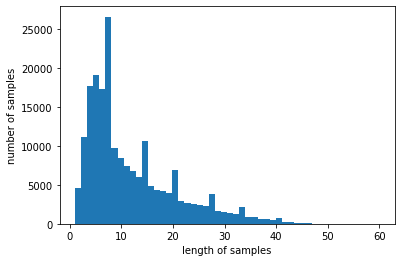

In [18]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰는 작업
# 전체 데이터에서 가장 길이가 긴 리뷰와, 전체의 길이분포를 알아보자
print('리뷰의 최대 길이 :',max(len(l) for l in X_total))
print('리뷰의 평균 길이 :',sum(map(len, X_total))/len(X_total))
plt.hist([len(s) for s in X_total], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# 최적의 길이를 찾기 위해, 전체 샘플중 길이가 max_len 이하인 샘플의 비율을 확인하는 함수 생성
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [20]:
# 30 이하 비율 체크
max_len = 30
below_threshold_len(max_len, X_total)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.96780133398047


In [21]:
# 짧은 데이터는 0을 채우고, 30을 넘는 긴 데이터는 손실됨
X_total = pad_sequences(X_total, maxlen = max_len)

# LSTM/GRU/BiLSTM 모델 훈련

In [22]:
# 필요한 프레임워크 및 라이브러리 임포트
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
# 임베딩 벡터의 차원은 100으로, 리뷰분류를 위해 LSTM 사용
# 왜 100인지는 모름
model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, 100))
model_LSTM.add(LSTM(128))
model_LSTM.add(Dense(1, activation='sigmoid'))

In [24]:
model_GRU = Sequential()
model_GRU.add(Embedding(vocab_size, 100))
model_GRU.add(GRU(128))
model_GRU.add(Dense(1, activation='sigmoid'))

In [25]:
model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(vocab_size, 100))
model_BiLSTM.add(Bidirectional(LSTM(128)))
model_BiLSTM.add(Dense(1, activation='sigmoid'))

In [26]:
# 검증 데이터 손실이 4회 증가하면 학습 조기 종료
# model check point를 사용하여 검증 데이터의 정확도가 이전보다 좋아질 경우만 모델 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_LSTM = ModelCheckpoint('RNN_LSTM_KoNLPy(Okt)_naver_shopping_review_v0.2.1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mc_GRU = ModelCheckpoint('RNN_GRU_KoNLPy(Okt)_naver_shopping_review_v0.2.1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mc_BiLSTM = ModelCheckpoint('RNN_BiLSTM_KoNLPy(Okt)_naver_shopping_review_v0.2.1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [27]:
# 필요한 매트릭 선언, AUC-ROC, F1-Score, AUC-PR 에 필요한 지표 모두 체크
import tensorflow as tf

ROCauc = tf.keras.metrics.AUC(curve="ROC") # auc_1
PRauc = tf.keras.metrics.AUC(curve="PR") # auc_2
RECALL = tf.keras.metrics.Recall()
PRECISION = tf.keras.metrics.Precision()
TP = tf.keras.metrics.TruePositives()
TN = tf.keras.metrics.TrueNegatives()
FP = tf.keras.metrics.FalsePositives()
FN = tf.keras.metrics.FalseNegatives()

In [28]:
# LSTM모델 훈련
model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_LSTM.fit(X_total, y_total, epochs=15, callbacks=[es, mc_LSTM], batch_size=100, validation_split=0.2)

Epoch 1/15
1599/1599 [==============================] - 30s 14ms/step - loss: 0.2804 - acc: 0.8914 - auc: 0.9508 - auc_1: 0.9433 - recall: 0.8982 - precision: 0.8863 - true_positives: 71874.0000 - true_negatives: 70643.0000 - false_positives: 9222.0000 - false_negatives: 8143.0000 - val_loss: 0.2491 - val_acc: 0.9050 - val_auc: 0.9606 - val_auc_1: 0.9535 - val_recall: 0.9031 - val_precision: 0.9059 - val_true_positives: 17975.0000 - val_true_negatives: 18199.0000 - val_false_positives: 1868.0000 - val_false_negatives: 1929.0000

Epoch 00001: val_acc improved from -inf to 0.90501, saving model to RNN_LSTM_KoNLPy(Okt)_naver_shopping_review_v0.2.1.h5
Epoch 2/15
1599/1599 [==============================] - 20s 12ms/step - loss: 0.2324 - acc: 0.9128 - auc: 0.9653 - auc_1: 0.9599 - recall: 0.9194 - precision: 0.9076 - true_positives: 73566.0000 - true_negatives: 72372.0000 - false_positives: 7493.0000 - false_negatives: 6451.0000 - val_loss: 0.2347 - val_acc: 0.9106 - val_auc: 0.9649 - val_a

In [29]:
# GRU모델 훈련
model_GRU.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_GRU.fit(X_total, y_total, epochs=15, callbacks=[es, mc_GRU], batch_size=100, validation_split=0.2)

Epoch 1/15
1599/1599 [==============================] - 26s 14ms/step - loss: 0.2778 - acc: 0.8931 - auc: 0.9539 - auc_1: 0.9463 - recall: 0.9043 - precision: 0.8914 - true_positives: 90357.0000 - true_negatives: 88919.0000 - false_positives: 11013.0000 - false_negatives: 9564.0000 - val_loss: 0.2466 - val_acc: 0.9071 - val_auc: 0.9614 - val_auc_1: 0.9555 - val_recall: 0.9064 - val_precision: 0.9071 - val_true_positives: 18040.0000 - val_true_negatives: 18219.0000 - val_false_positives: 1848.0000 - val_false_negatives: 1864.0000

Epoch 00001: val_acc improved from -inf to 0.90713, saving model to RNN_GRU_KoNLPy(Okt)_naver_shopping_review_v0.2.1.h5
Epoch 2/15
1599/1599 [==============================] - 20s 13ms/step - loss: 0.2313 - acc: 0.9132 - auc: 0.9656 - auc_1: 0.9601 - recall: 0.9204 - precision: 0.9074 - true_positives: 73649.0000 - true_negatives: 72353.0000 - false_positives: 7512.0000 - false_negatives: 6368.0000 - val_loss: 0.2339 - val_acc: 0.9116 - val_auc: 0.9654 - val_a

In [30]:
# BiLSTM모델 훈련
model_BiLSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_BiLSTM.fit(X_total, y_total, epochs=15, callbacks=[es, mc_BiLSTM], batch_size=100, validation_split=0.2)

Epoch 1/15
1599/1599 [==============================] - 35s 17ms/step - loss: 0.2830 - acc: 0.8905 - auc: 0.9526 - auc_1: 0.9458 - recall: 0.9029 - precision: 0.8880 - true_positives: 90218.0000 - true_negatives: 88551.0000 - false_positives: 11381.0000 - false_negatives: 9703.0000 - val_loss: 0.2521 - val_acc: 0.9042 - val_auc: 0.9595 - val_auc_1: 0.9525 - val_recall: 0.9138 - val_precision: 0.8959 - val_true_positives: 18189.0000 - val_true_negatives: 17953.0000 - val_false_positives: 2114.0000 - val_false_negatives: 1715.0000

Epoch 00001: val_acc improved from -inf to 0.90421, saving model to RNN_BiLSTM_KoNLPy(Okt)_naver_shopping_review_v0.2.1.h5
Epoch 2/15
1599/1599 [==============================] - 25s 16ms/step - loss: 0.2346 - acc: 0.9116 - auc: 0.9646 - auc_1: 0.9591 - recall: 0.9194 - precision: 0.9054 - true_positives: 73571.0000 - true_negatives: 72181.0000 - false_positives: 7684.0000 - false_negatives: 6446.0000 - val_loss: 0.2388 - val_acc: 0.9103 - val_auc: 0.9644 - va

# LSTM/GRU/BiLSTM 모델 성능평가

In [ ]:
# 평가용 토탈 데이터셋2(화장품+앱)

# 데이터 로드
total_data2 = pd.read_table('total_data(app&cosmetic).txt')

# 토크나이징
X_test_total2 = []
for sentence in total_data2['document']:
    temp_X2 = okt.morphs(sentence, stem=True)
    temp_X2 = [word for word in temp_X2 if not word in stopwords]
    X_test_total2.append(temp_X2)

# 워드 벡터화
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_test_total2)
X_test_total2 = tokenizer.texts_to_sequences(X_test_total2)

# 패딩
X_test_total2 = pad_sequences(X_test_total2, maxlen = max_len)

# 라벨데이터 포함
y_test_total2 = np.array(total_data2['label'])

FileNotFoundError: ignored

In [ ]:
# LSTM모델 성능 평가 
loaded_model = load_model('RNN_LSTM_KoNLPy(Okt)_naver_shopping_review_v0.2.1.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n LSTM 테스트 결과:",result)

In [ ]:
# GRU모델 성능 평가 
loaded_model = load_model('RNN_GRU_KoNLPy(Okt)_naver_shopping_review_v0.2.1.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n GRU 테스트 결과:",result)

In [ ]:
# BiLSTM모델 성능 평가 
loaded_model = load_model('RNN_BiLSTM_KoNLPy(Okt)_naver_shopping_review_v0.2.1.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n BiLSTM 테스트 결과:",result)